In [1]:
import numpy as np
import nltk
import keras
import gensim

/Users/jonathanbleiberg/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from nltk.corpus import brown
import gensim.downloader as gdl

pretrained_glove = gdl.load('glove-wiki-gigaword-100')

In [14]:
import random

# extract all trigrams that have a vector representation
def get_trigrams(words, model, doc_id):
    trigrams = [None for _ in range(len(words) - 2)]
    for i in range(len(words) - 2):
        # loop through all trigrams in text
        curr_trigram = (words[i], words[i+1], words[i+2], doc_id)
        # include trigram if all words have a vector representation
        if curr_trigram[0] in model and curr_trigram[1] in model and curr_trigram[2] in model:
            trigrams[i] = curr_trigram
    return [tri for tri in trigrams if tri is not None]

# perturb the second word of each trigram
def get_perturbations_by_synonym(trigrams, model):
    perturbed_trigrams = [None for _ in range(len(trigrams))]
    wn_lemmas = set(wn.all_lemma_names())
    rand_idxs = np.random.randint(0,2,len(trigrams))
    n_syns = 0
    for idx, tri in enumerate(trigrams):
        if idx % 1000 == 0:
            print(idx)
            print(n_syns)
        # get 1st-3rd most similar word to middle word of trigram
        if tri[1] in wn_lemmas:
            syns = [w for w in random.choice(wn.synsets(tri[1])).lemma_names() if w != tri[1] and w in model]
            if syns != []:
                n_syns += 1
                perturbed_trigrams[idx] = random.choice(syns)
        else:
            perturbed_trigrams[idx] = model.most_similar(tri[1], topn=3)[rand_idxs[idx]][0]
    
    return perturbed_trigrams

# create trigram and perturbed word dataset
def create_dataset_v2(words, model, doc_id):
    trigrams = get_trigrams(words, model, doc_id)
    perturbed_trigrams = get_perturbations_by_synonym(trigrams, model)
    return trigrams, perturbed_trigrams

In [16]:
from nltk.corpus import wordnet as wn

full_tris, full_perturbed_v2 = [],[]
for idx, cat in enumerate(brown.categories()):
    print(cat)
    %time trigrams, perturbed = create_dataset_v2(brown.words(categories=cat)[:5000], pretrained_glove, idx)
    full_tris += trigrams
    full_perturbed_v2 += perturbed

adventure
0
0
1000
275
2000
525
3000
798
CPU times: user 1min 12s, sys: 290 ms, total: 1min 12s
Wall time: 40.6 s
belles_lettres
0
0
1000
293
2000
594
3000
898
CPU times: user 1min 16s, sys: 1.32 s, total: 1min 17s
Wall time: 43.8 s
editorial
0
0
1000
298
2000
617
3000
953
CPU times: user 1min, sys: 970 ms, total: 1min 1s
Wall time: 34.8 s
fiction
0
0
1000
308
2000
601
3000
906
CPU times: user 1min 11s, sys: 957 ms, total: 1min 12s
Wall time: 41.1 s
government
0
0
1000
313
2000
621
3000
956
CPU times: user 1min 12s, sys: 793 ms, total: 1min 13s
Wall time: 41.5 s
hobbies
0
0
1000
289
2000
583
3000
878
CPU times: user 1min 10s, sys: 802 ms, total: 1min 11s
Wall time: 40.3 s
humor
0
0
1000
277
2000
558
3000
831
CPU times: user 1min 20s, sys: 944 ms, total: 1min 21s
Wall time: 46.5 s
learned
0
0
1000
288
2000
611
3000
930
CPU times: user 1min 16s, sys: 628 ms, total: 1min 17s
Wall time: 43.4 s
lore
0
0
1000
325
2000
614
3000
901
CPU times: user 1min 15s, sys: 617 ms, total: 1min 16s
Wall t

In [17]:
# build the vocabulary and create dictionaries to convert between word and index
def build_vocab(trigrams, perturbed_trigrams):
    # extract all words in input and output
    words = [i for i, _, _, _ in trigrams] + [trigrams[-1][1]] + [trigrams[-1][2]]
    words += [i for i in perturbed_trigrams]
    # get unique words
    vocab = set(words)
    
    # create dicts to conver index
    word2idx = {word:idx for idx, word in enumerate(vocab)}
    idx2word = {idx:word for idx, word in enumerate(vocab)}
    return vocab, word2idx, idx2word

In [19]:
vocab, word2idx, idx2word = build_vocab(full_tris, full_perturbed_v2)

In [20]:
# convert trigrams to concatenated vector representation
def trigrams_to_matrix(trigrams, model, vec_size):
    word_input_matrix = np.zeros((len(trigrams), vec_size * 3))
    for idx, tri in enumerate(trigrams):
        word_input_matrix[idx] = np.concatenate((model.get_vector(tri[0]),
                                                 model.get_vector(tri[1]), 
                                                 model.get_vector(tri[2])))
    return word_input_matrix
# convert perturbed words to array of integer labels
def perturbed_to_labels(perturbed, word2idx):
    return np.array([word2idx[w] for w in perturbed])

# extract document ids as np array
def doc_ids_to_vec(trigrams):
    return np.array([idx for _, _, _, idx in trigrams])

In [22]:
word_input_mat = trigrams_to_matrix(full_tris, pretrained_glove, 100)
labels = perturbed_to_labels(full_perturbed_v2, word2idx)
doc_ids = doc_ids_to_vec(full_tris)

In [23]:
from sklearn.preprocessing import LabelBinarizer
# convert interger labels to one hot encoding
def convert_to_one_hot(labels, vocab_size):
    one_hot_encoder = LabelBinarizer()
    one_hot_encoder.fit(range(vocab_size))
    labels_one_hot = one_hot_encoder.transform(labels)
    return labels_one_hot

In [24]:
labels_one_hot = convert_to_one_hot(labels, len(vocab))

In [25]:
from keras.models import Model
from keras.layers import Embedding, Dense, Input

embedding_dim = 50  # dimension of document embedding
n_docs = len(brown.categories())  # number of docs in corpus
vec_dim = 100  # dimension of word embedding vectors
hidden_size = 128  # dimension of hidden layer
vocab_size = len(vocab) # number of words in vocab
batch_size = 64 



# input layer for document id
doc_input = Input(shape=(1,), name="doc_input", dtype='int32')
# input layer for concatenated word vectors
words_input = Input(shape=(vec_dim*3,), name="word1_input", dtype='float32')

# document embedding layer
x_1 = keras.layers.Flatten()(Embedding(input_dim=n_docs, output_dim=embedding_dim, name='embeddings')(doc_input))
# concatenate document andword embeddings
X = keras.layers.concatenate([x_1, words_input])
# pass through hidden layer
X = Dense(hidden_size, activation='relu')(X)
# output softmax probailities
output = Dense(vocab_size, activation='softmax')(X)

model = Model(inputs = [doc_input, words_input], outputs=[output])

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [27]:
# train for 20 epochs
model.fit([doc_ids, word_input_mat], [labels_one_hot], epochs=20, batch_size=batch_size)

Epoch 1/20
53020/53020 [==============================] - 105s 2ms/step - loss: 4.3196
Epoch 2/20
53020/53020 [==============================] - 103s 2ms/step - loss: 2.8952
Epoch 3/20
53020/53020 [==============================] - 102s 2ms/step - loss: 2.1678
Epoch 4/20
53020/53020 [==============================] - 102s 2ms/step - loss: 1.5582
Epoch 5/20
53020/53020 [==============================] - 102s 2ms/step - loss: 1.1538
Epoch 6/20
53020/53020 [==============================] - 102s 2ms/step - loss: 0.9290
Epoch 7/20
53020/53020 [==============================] - 102s 2ms/step - loss: 0.8045
Epoch 8/20
53020/53020 [==============================] - 102s 2ms/step - loss: 0.7284
Epoch 9/20
53020/53020 [==============================] - 101s 2ms/step - loss: 0.6642
Epoch 10/20
53020/53020 [==============================] - 102s 2ms/step - loss: 0.6146
Epoch 11/20
53020/53020 [==============================] - 103s 2ms/step - loss: 0.5725
Epoch 12/20
53020/53020 [================

In [28]:
model.save('brown_first_5000_v2.h5')

In [29]:
embed = model.layers[1].get_weights()[0]

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


scaler = StandardScaler()
standardized_embeddings = scaler.fit_transform(embed)

tsne_1 = TSNE(random_state=42, perplexity=2)
embeddings_2d_tsne = tsne_1.fit_transform(standardized_embeddings)

pca_1 = PCA(n_components=2)
embeddings_2d_pca = pca_1.fit_transform(standardized_embeddings)

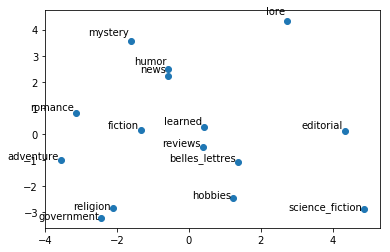

In [37]:
import matplotlib.pyplot as plt

plt.scatter(embeddings_2d_pca[:,0], embeddings_2d_pca[:,1])

for label, x, y in zip(brown.categories(), embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2, y),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

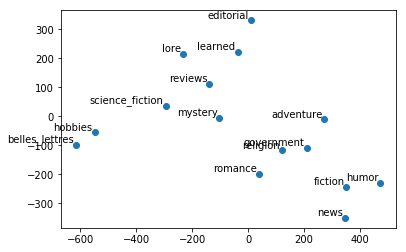

In [38]:
plt.scatter(embeddings_2d_tsne[:,0], embeddings_2d_tsne[:,1])

for label, x, y in zip(brown.categories(), embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2,0),
        textcoords='offset points', ha='right', va='bottom')
plt.show()